In [13]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from collections import defaultdict
from fastai.core import Path
import matplotlib.pyplot as plt
import numpy as np
from image_graph import get_image_array
%matplotlib inline
%reload_ext autoreload
%autoreload 2

<p style="font-size:13px;color:#FFB5A4">In this notebook I demonstrate the way I estimate linesplits in an image</p>
<p style="font-size:13px;color:#FFB5A4">The basic idea is to find the lines in the image with the highest sum of pixel values, this indicates a high number of white pixels, and so is a good candidate for a line split. You then find the two minimum inflection points on either side of that white line, indicating the middle of the lines above and below. You then create a sub-graph containing the space between these two lines of text through which you can cut to separate the lines.</p>

In [14]:
im_path = Path('../greek_pages/line_images/LAT_RDR_PG3')
im_name = im_path/'line_41.jpeg'

img_arr = get_image_array(im_name)

In [15]:
from split_multi import *

In [53]:
get_sp_ims(img_arr, .5)

([Image (3, 2484, 116)], [Image (3, 2484, 69)])

In [54]:
ims = _

In [55]:
im1 = ims[0][0]

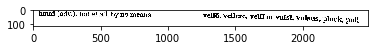

In [65]:
plt.imshow(im1.flip_lr().data[0].T, cmap = 'gist_gray')

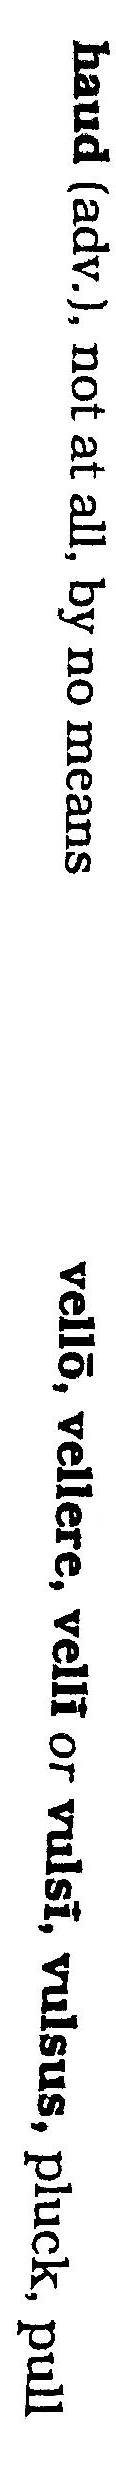

In [57]:
im1.flip_lr()

In [50]:
ims[0][0].flip_lr().data.T

tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])

In [52]:
imwrite('/Users/nicholasbangs/Desktop/line.jpg', ims[1][0].flip_lr().data.T)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [11]:
# create my own sign definition to return -1 if x,y are equal
def sign(x, y):
    if x > y:
        return 1
    else:
        return -1

<p style="font-size:13px;color:#FFB5A4">I determine the estimate linesplits using the following algorithm:</p>
<ul style="font-size:13px;color:#FFB5A4">
    <li>For each row in the image, calculate the sum of the pixel values</li>
    <li>Get the max and min linesums</li>
    <li>Define DELTA which is 15 percent of the difference between the top and bottom values. This is used to define a threshold for how long the pixel values must either increase or decrease before counting the last observed max/min as a peak or valley</li>
    <li>Create dictionaries to store both the max and min pixel sums as well as the locations where they are found</li>
    <li>Define smooth_changes which is used to create a buffer between a change in linesum velocity (pos. or neg.) and the decision to count it as a peak or valley. This is because there is quite a bit of noise, so even if a change in velocity happens, it will most likely not be either a max or min point. The buffer period is defined by DELTA, basically it is just how long do we have to see a constant change in velocity before saying we really had peak/valley</li>
    <li>Define velocity, used above, which indicates the direction that the linesums are moving as you move along the rows</li>
    <li>Initialize the prev variable (previous velocity) to None</li>
    <li>fundict is a dictionary to map an integer to either the min or max function, these are used to get the smallest or largest points found in smooth changes after the threshold is met</li>
</ul>

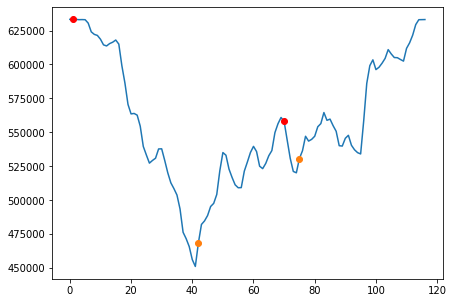

In [12]:
linesums = [g.sum() for g in img_arr]
LO, HI = min(linesums), max(linesums)
DELTA = (HI - LO) * .15
vchanges = defaultdict(list)
vcvals = defaultdict(list)
smooth_changes = defaultdict(list)
velocity = -4
prev = None
fundict = {1: min, -1: max}
for i in range(1, len(linesums)):
    x = linesums[i]
    prev_velocity = velocity
    velocity = sign(x, linesums[i-1])
    if prev_velocity != velocity: # if a velocity change is found, add to smooth changes
        smooth_changes[velocity].append((i,x))
    if (prev_velocity == velocity) and (smooth_changes != {}) and (velocity != prev):
        if np.abs(np.long(x) - np.long(smooth_changes[velocity][-1][1])) > DELTA: # if the threshold has been met, get the min/max value
            vc = fundict[velocity](smooth_changes[velocity], key=lambda x: x[1])
            vchanges[velocity].append(vc[0])
            vcvals[velocity].append(vc[1])
            smooth_changes = defaultdict(list)
            prev = velocity
            
plt.figure(figsize=(7,5))
plt.plot(linesums)
plt.plot(vchanges[-1],vcvals[-1],'ro')
plt.plot(vchanges[1],vcvals[1],'o')

<p style="font-size:13px;color:#FFB5A4">In order to get one row per line split, I take the pixels which I determine to be at the peak points in the pixel sum graph above (these are the red dots - see alg. above). The algorithm I wrote sometimes picks the wrong points as peaks (4th red dot), so below I have a filter to choose only those dots that are in the top level. This is just any pixel that is within 2 times the DELTA variable of the maximum linesum value as below:</p>

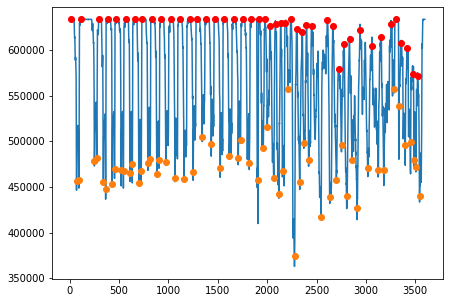

In [6]:
peaks = zip(vchanges[-1], vcvals[-1])
peaks = [v for v in peaks if v[1] > max(vcvals[-1]) - DELTA*2]
vchanges[-1] = [p[0] for p in peaks]
vcvals[-1] = [p[1] for p in peaks]
plt.figure(figsize=(7,5))
plt.plot(linesums)
plt.plot(vchanges[-1], vcvals[-1],'ro')
plt.plot(vchanges[1],vcvals[1],'o')

<p style="font-size:13px;color:#FFB5A4">This graph now correctly filters all of the line splits, so we can now use it to create the correct number of lines (orange dots). This will be done by picking one orange dot between each pair of red dots, taking the minimum of the available values.</p>

In [7]:
def get_point_and_val(indices, rows, vals): # helper function for code below
    if len(indices) > 1:
        min_index = indices[np.argmin(vals[indices[0]:indices[1]+1])]
        minpoint = rows[min_index]
        minval = vals[min_index]
    else:
        minpoint = rows[indices[0]]
        minval = vals[indices[0]]
    return minpoint, minval

In [8]:
# get one row per line
line_points = []
line_vals = []
for i in range(1, len(vchanges[-1])):
    lb = vchanges[-1][i-1]
    ub = vchanges[-1][i]
    indices = [vchanges[1].index(v) for v in vchanges[1] if v > lb and v < ub]
    minpoint, minval = get_point_and_val(indices, vchanges[1], vcvals[1])
    line_points.append(minpoint)
    line_vals.append(minval)
    
indices = [vchanges[1].index(v) for v in vchanges[1] if v > vchanges[-1][-1] and v < img_arr.shape[0]]
if len(indices) > 0:
    minpoint, minval = get_point_and_val(indices, vchanges[1], vcvals[1])
    line_points.append(minpoint)
    line_vals.append(minval)

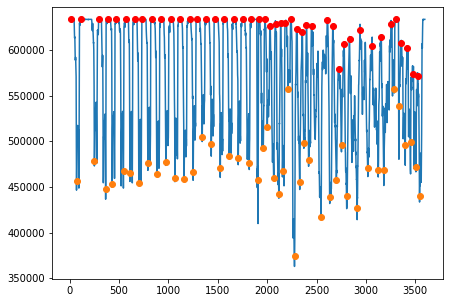

In [9]:
plt.figure(figsize=(7,5))
plt.plot(linesums)
plt.plot(vchanges[-1],vcvals[-1],'ro')
plt.plot(line_points, line_vals,'o')

<p style="font-size:13px;color:#FFB5A4">Now we have a graph with one row per line and one row per linesplit</p>

<p style="font-size:13px;color:#FFB5A4">Finally, the rows determined to be peaks are used to generate subgraphs of the image, these sub-graphs are the area from the middle of the top line to the middle of the bottom line. I then use Dijkstra's Shortest Path algorithm to find a split from the left of the image to the right, separating the two lines - see the notebook called get_lines</p>